In [1]:
%matplotlib inline

#- import required python libraries
import netCDF4
import sys, os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import glofrim.glofrim_lib as glib
from os.path import join, isfile, abspath, dirname, basename, normpath
from configparser import ConfigParser
from glofrim.glofrim_lib import configread

In [2]:
from glofrim import Glofrim, PCR, CMF
cbmi = Glofrim()

In [3]:
#- provide file with local paths to model objects
env_fn = r'../../environment.env'
config = configread(env_fn)
root_dir = config.get('models', 'root_dir')

In [4]:
#- convert model configs to dictionary
_cf = ConfigParser(inline_comment_prefixes=('#'))
env = glib.configread(abspath(env_fn), encoding='utf-8', cf=_cf)
glib.config2dict(env)

OrderedDict([(u'engines',
              OrderedDict([('CMF',
                            u'/home/jannis/Programmes/cama-flood_bmi_v3.6.2/src/libcama.so'),
                           ('DFM',
                            u'/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'),
                           ('LFP',
                            u'/home/jannis/Programmes/lisflood-bmi-v5.9/liblisflood.so')])),
             (u'models',
              OrderedDict([('root_dir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe')]))])

In [5]:
#- provide file with coupling settings
config_fn = join(root_dir, 'glofrim_PCR2CMF.ini')
# config_fn = join(root_dir, 'glofrim_PCR2DFM.ini')
# config_fn = join(root_dir, 'glofrim_WFL2DFM.ini')
# config_fn = join(root_dir, 'glofrim_PCR2LFP.ini')
config_fn

u'/home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/glofrim_PCR2CMF.ini'

In [6]:
#- provide locations where to extract simulated discharge
x_obs_coord = 10.89 # set to coords of Neu-Darchau
y_obs_coord = 53.23

In [7]:
#- create coupled GLOFRIM model and initialize configs
try:
    cbmi.initialize_config(config_fn, env_fn=env_fn)
except Exception as e:
    print e
    sys.exit('configs could not be initialized')

2018-07-24 12:08:38,732 - PCR - INFO - Config initialized
2018-07-24 12:08:38,748 - CMF - INFO - Config initialized


In [8]:
#- provide start and end date
t_start = datetime(2000,1,1)
t_end = datetime(2000,1,3)
cbmi.set_start_time(t_start)
cbmi.set_end_time(t_end)
try:
    t_start == cbmi.get_start_time()
    t_end == cbmi.get_end_time()
except:
    sys.exit('start or end time differ with set_var and get_var')

In [9]:
#- create coupled GLOFRIM model and initialize models
try:
    cbmi.initialize_model()
except Exception as e:
    print e
    sys.exit('models could not be initialized')

2018-07-24 12:08:38,847 - PCR - INFO - Getting rgrid info based on landmask_elbe_30min.map
2018-07-24 12:08:38,850 - PCR - INFO - Getting drainage direction from ldd_elbe_30min.map
2018-07-24 12:08:38,853 - CMF - INFO - Getting Unit-Catchment Grid info based on nextxy.tif
2018-07-24 12:08:38,855 - CMF - INFO - Getting drainage direction from nextxy.tif
2018-07-24 12:08:38,903 - PCR - WARNING - /home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe_glofrim.ini file overwritten
2018-07-24 12:08:38,906 - PCR - INFO - Ini file written to /home/jannis/PhD/code/GLOFRIMplusCAMA/model_test_data/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe_glofrim.ini
2018-07-24 12:08:38,912 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-07-24 12:08:38.908038
2018-07-24 12:08:38,913 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/experiment_GLOFRIM2/PCR/log/setup_PCR_30min_Elbe.ini_2018-07-24T12:08:38.908038.log
201

In [10]:
#- get corresponding indices for models
obs_ind_PCR = cbmi.index(x_obs_coord, y_obs_coord, 'PCR', in1d=False)
print obs_ind_PCR
obs_ind_CMF = cbmi.index(x_obs_coord, y_obs_coord, 'CMF', in1d=False)
print obs_ind_CMF

2018-07-24 12:08:47,225 rasterio.env DEBUG Entering env context: <rasterio.env.Env object at 0x7fe64537bd10>
2018-07-24 12:08:47,226 rasterio.env DEBUG Starting outermost env
2018-07-24 12:08:47,228 rasterio.env DEBUG No GDAL environment exists
2018-07-24 12:08:47,229 rasterio.env DEBUG New GDAL environment <rasterio._env.GDALEnv object at 0x7fe64a840f10> created
2018-07-24 12:08:47,230 rasterio._env DEBUG Logging error handler pushed.
2018-07-24 12:08:47,232 rasterio._env DEBUG All drivers registered.
2018-07-24 12:08:47,233 rasterio._env DEBUG Started GDALEnv <rasterio._env.GDALEnv object at 0x7fe64a840f10>.
2018-07-24 12:08:47,234 rasterio.env DEBUG Entered env context: <rasterio.env.Env object at 0x7fe64537bd10>
2018-07-24 12:08:47,236 rasterio._base DEBUG Got coordinate system
2018-07-24 12:08:47,237 rasterio._base DEBUG Authority key: EPSG, value: 4326
2018-07-24 12:08:47,238 rasterio._base DEBUG Nodata success: 1, Nodata value: -9999.000000
2018-07-24 12:08:47,239 rasterio._base

[67]
[255]


In [11]:
#- update models until end time is reached
#- also, read out discharge data at specified observation point
print 'running simulation from ', str(cbmi.get_start_time()),' to ', str(cbmi.get_end_time())
while cbmi.get_current_time() < cbmi.get_end_time():
    print cbmi.get_current_time()
    cbmi.update()
    q_sim_PCR = cbmi.get_value_at_indices('PCR.discharge', obs_ind_PCR)
    q_sim_CMF = cbmi.get_value_at_indices('CMF.outflw', obs_ind_CMF) # does not recognize CMF.rivout
    print q_sim_PCR, q_sim_CMF # seems to work for PCR, not so much for CMF.outflw (it's always 0)

2018-07-24 12:08:47,358 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01


running simulation from  2000-01-01 00:00:00  to  2000-01-03 00:00:00
2000-01-01 00:00:00


2018-07-24 12:08:47,524 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-07-24 12:08:48,821 - CMF - INFO - updated model to datetime 2000-01-02
2018-07-24 12:08:48,821 CMF INFO updated model to datetime 2000-01-02
2018-07-24 12:08:48,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
2018-07-24 12:08:48,984 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-02


[ 1364.76916504] [ 0.]
2000-01-02 00:00:00


2018-07-24 12:08:49,673 - CMF - INFO - updated model to datetime 2000-01-03
2018-07-24 12:08:49,673 CMF INFO updated model to datetime 2000-01-03


[ 2121.3828125] [ 0.]


In [12]:
#- check dimensions of output maps
CMF_outflw = cbmi.get_value("CMF.outflw")
print CMF_outflw.shape 
PCR_discharge = cbmi.get_value('PCR.discharge')
print PCR_discharge.shape

(40, 28)
(14, 20)


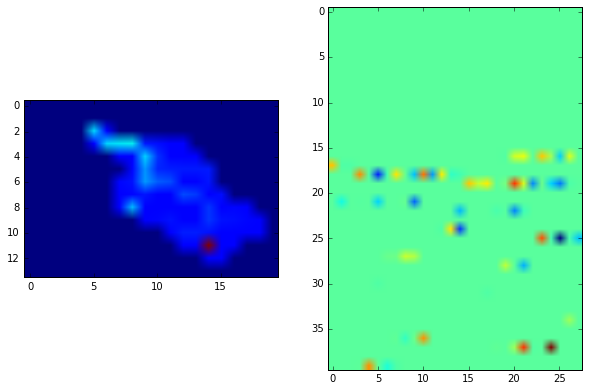

In [13]:
#- check whether plots are correct
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(PCR_discharge)
plt.subplot(122)
plt.imshow(CMF_outflw) # this does not look as it's supposed to...

In [14]:
#- finalize all models
try:
    cbmi.finalize()
except Exception as e:
    print e
    sys.exit('models could not be finalized')

2018-07-24 12:08:50,010 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/glofrim-py/tests
